In [1]:
PATH_TO_RESOURCES = "../resources/train"

## Récupérations des images

In [2]:
import cv2

In [3]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [4]:
symbols = [cv2.cvtColor(cv2.imread(symbol_file), cv2.COLOR_BGR2RGB) for symbol_file in symbol_files]

## Récupération des labels

In [5]:
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(symbols, symbols_labels, test_size=0.2, stratify=symbols_labels)

# Transformateurs

In [8]:
import numpy as np

### Extraction de symboles

In [9]:
class RGBSymbolExtractor():
    def fit(self, X, y=None, sample_weight=None):
        return self
    
    def transform(self, X, copy=None):
        return [symbol[np.sum(symbol, axis=2) < 255 * 3] for symbol in X]

# Extraction de caractéristiques

In [10]:
from sklearn.cluster import MiniBatchKMeans

## Histogramme couleur

### Explications

Voir le notebook [`color_histogram.ipynb`](http://localhost:8888/notebooks/color_histogram.ipynb).

In [11]:
class ColorHistogram():
    def __init__(self):
        self.kmeans = MiniBatchKMeans(8)
        
    def fit(self, X, y=None, sample_weight=None):
        sample_pixels = X[0]
        for i in range(1, len(X)):
            sample_pixels = np.concatenate((sample_pixels, X[i]), axis=0)

        self.kmeans.fit(sample_pixels)
        
        return self
    
    def transform(self, X, copy=None):
        histograms = []
        for i in range(len(X)):
            histo = np.bincount(np.uint8(self.kmeans.predict(X[i])),
                        minlength = self.kmeans.n_clusters) / len(X[i])
            histograms.append(histo)

        return histograms

## Hu Moments

### Explications

Voir le notebook [`moments.ipynb`](http://localhost:8888/notebooks/moments.ipynb).

### Etape de pipeline

In [12]:
import cv2
from math import copysign, log10

In [13]:
class HuMoments():
    def __init__(self):
        pass
        
    def fit(self, X, y=None, sample_weight=None):
        return self
    
    def transform(self, X, copy=None):
        X_gray = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X]
        huMoments = []

        for i in range(len(X)):
            # Calculate Moments
            moments = cv2.moments(X_gray[i])
            # Calculate Hu Moments
            theseHuMoments = cv2.HuMoments(moments)

            # Log scale hu moments
            for i in range(0,7):
                theseHuMoments[i] = -1* copysign(1.0, theseHuMoments[i]) * log10(abs(theseHuMoments[i]))

            huMoments.append(theseHuMoments.reshape((7,)))
            
        return huMoments

## Transformée de Fourier

### Explications

Voir le notebook

In [14]:
class Grayscale():
    def fit(self, X, y=None, sample_weight=None):
        return self
    
    def to_grayscale(self, img):
        h,w,_ = img.shape
        result = np.ones((h,w)) * 255
        result[:h,:w] = (np.sum(img, axis=2) / 3) / 255

        return result
    
    def transform(self, X, copy=None):
        return [self.to_grayscale(X[i]) for i in range(len(X))]

In [15]:
class BoundaryTransform():
    def fit(self, X, y=None, sample_weight=None):
        max_h, max_w = 0, 0
        for img in X:
            h, w = img.shape
            if h > max_h:
                max_h = h

            if w > max_w:
                max_w = w

        self.bounding_shape = (max_h, max_w)
        
        return self
    
    def adapt_to_bounding_shape(self, image, bounding_shape):
        result = np.ones(bounding_shape)

        h, w = image.shape
        b_h, b_w = bounding_shape
        max_h = h if b_h > h else b_h
        max_w = w if b_w > w else b_w

        result[:max_h,:max_w] = image[:max_h,:max_w]

        return result
    
    def transform(self, X, copy=None):
        bounded = []
        for symbol in X:
            if symbol.shape > self.bounding_shape:
                h_ratio = symbol.shape[0] / self.bounding_shape[0]
                w_ratio = symbol.shape[1] / self.bounding_shape[1]
                scale_fact = 1 / max(h_ratio, w_ratio)
                resized = cv2.resize(symbol, (symbol.shape[0] * scale_fact, symbol.shape[1] * scale_fact))
                bounded.append(self.adapt_to_bounding_shape(resized, self.bounding_shape))
            else:
                bounded.append(self.adapt_to_bounding_shape(symbol, self.bounding_shape))
            
        return np.array(bounded)

In [16]:
class GraySymbolExtractor():
    def __init__(self):
        self.masks = []
        
    def fit(self, X, y=None, sample_weight=None):
        for symbol in X:
            self.masks.append(symbol < 1)
        
        return self
    
    def transform(self, X, copy=None):
        return [X[i].flatten() for i in range(len(X))]

In [17]:
class FourierTransform():
    def fourier_transform(self, img):
        ft = np.fft.fftshift(np.fft.fft(img))
        return np.log(abs(np.where(ft == 0, np.finfo(float).eps, ft)))

    def fit(self, X, y=None, sample_weight=None):
        
        return self
    
    def transform(self, X, copy=None):
        tmp = [self.fourier_transform(symbol).flatten() for symbol in X]
        maxLen = len(max(tmp, key = lambda e : len(e)))
        results = []
        for res in tmp:
            result = np.ones(maxLen) * np.finfo(np.float32).min
            result[:len(res)] = res
            results.append(result)
        
        return results

# Benchmark

Pour chaque classifieur de la liste ` classifiers` on va tester chaque extracteur de caractéristiques de la liste `extractors` ainsi que l'early fusion de ces mêmes extracteurs un à un.

Seront évalués sur le jeu de données test le score, le temps pour fit et le temps pour évaluer.

In [18]:
import time
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

In [19]:
color_histo_step = ("color histogram", Pipeline([("extraction", RGBSymbolExtractor()),
                                                 ("histogram", ColorHistogram())]))

In [20]:
fourier_step = ("fourier transform", Pipeline([("grasycale", Grayscale()),
                                     ("boundaries", BoundaryTransform()),
                                     ("extract", GraySymbolExtractor()),
                                     ("fourier", FourierTransform())]))

In [21]:
extractors = [color_histo_step, ("hu moments", HuMoments()), fourier_step]

In [22]:
classifiers_default = [
    ("dummy clf", DummyClassifier()),
    ("LinearSVC clf", LinearSVC()),
    ("KNeighbours clf", KNeighborsClassifier()),
    ("SVC clf", SVC()),
    ("Random Forest clf", RandomForestClassifier()),
]

In [23]:
def evaluate_pipeline(steps):
    fit_time = 0
    score_time = 0
    score = 0
    NB_STEP = 6
    for _ in range(NB_STEP):
        pipeline = Pipeline(steps)
        start = time.process_time()
        pipeline.fit(X_train, y_train)
        fit_time += time.process_time() - start

        start = time.process_time()
        score += pipeline.score(X_test, y_test)
        score_time += time.process_time() - start

    fit_time /= NB_STEP
    score_time /= NB_STEP
    score =  score / NB_STEP * 100

    return score, fit_time, score_time

In [24]:
def process_benchmark(extractors, classifiers):
    nb_tests = len(extractors) * len(classifiers)
    benchmark = []
    for i in range(len(classifiers)):
        clf = classifiers[i]
        print("Processing classifier: " + clf[0])
        for j in range(len(extractors)):
            extor = extractors[j]
            if clf[0] == "LinearSVC clf" and extor[0] == "fourier transform":
                    continue
            print("Processing extractor: " + extor[0])

            steps = [extor, clf]
            score, fit_time, score_time = evaluate_pipeline(steps)
            benchmark.append((clf[0],
                              extor[0],
                              "{:.3f} %".format(score),
                              "{:.3f} s".format(fit_time),
                              "{:.3f} s".format(score_time)))

            for k in range(j + 1, len(extractors)):
                if clf[0] == "LinearSVC clf" and extractors[k][0] == "fourier transform":
                    continue

                union_name = extor[0] + " + " + extractors[k][0]
                print("Processing extractors: " + union_name)
                steps = [(union_name, FeatureUnion([extor, extractors[k]])), clf]
                score, fit_time, score_time = evaluate_pipeline(steps)
                benchmark.append((clf[0],
                                  union_name,
                                  "{:.3f} %".format(score),
                                  "{:.3f} s".format(fit_time),
                                  "{:.3f} s".format(score_time)))
                
    return benchmark

In [25]:
benchmark_basic = process_benchmark(extractors, classifiers_default)

Processing classifier: dummy clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform
Processing classifier: LinearSVC clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments


/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinea

Processing extractor: hu moments


/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinea

Processing classifier: KNeighbours clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform
Processing classifier: SVC clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform
Processing classifier: Random Forest clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform


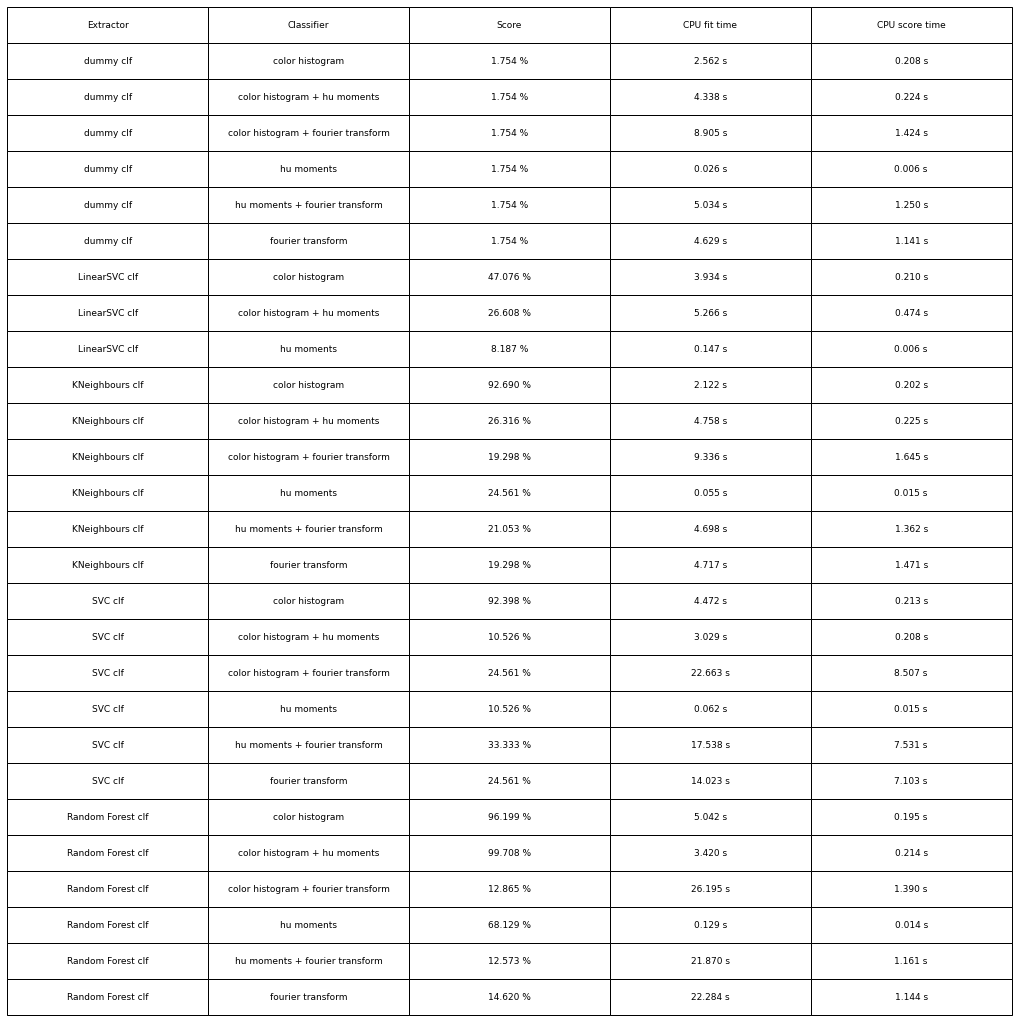

In [26]:
fig, ax =plt.subplots()
column_labels=["Extractor", "Classifier", "Score", "CPU fit time", "CPU score time"]
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=benchmark_basic,
                 colLabels=column_labels,
                 loc="center",
                 cellLoc="center")

table.set_fontsize(20)
table.scale(3, 3)

plt.show()

In [27]:
classifiers_opti = [
    ("dummy clf", DummyClassifier()),
    ("LinearSVC clf", LinearSVC(loss='squared_hinge',tol=0.0020,C=14,max_iter=5000)),
    ("KNeighbours clf", KNeighborsClassifier(n_neighbors=2,weights='distance',leaf_size=20)),
    ("SVC clf", SVC(C=9,kernel='rbf',degree=5)),
    ("Random Forest clf", RandomForestClassifier(n_estimators=90,criterion='entropy',min_samples_split=3,min_samples_leaf=2)),
]

In [28]:
benchmark_opti = process_benchmark(extractors, classifiers_opti)

Processing classifier: dummy clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform
Processing classifier: LinearSVC clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments


/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinea

Processing extractor: hu moments


/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinea

Processing classifier: KNeighbours clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform
Processing classifier: SVC clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform
Processing classifier: Random Forest clf
Processing extractor: color histogram
Processing extractors: color histogram + hu moments
Processing extractors: color histogram + fourier transform
Processing extractor: hu moments
Processing extractors: hu moments + fourier transform
Processing extractor: fourier transform


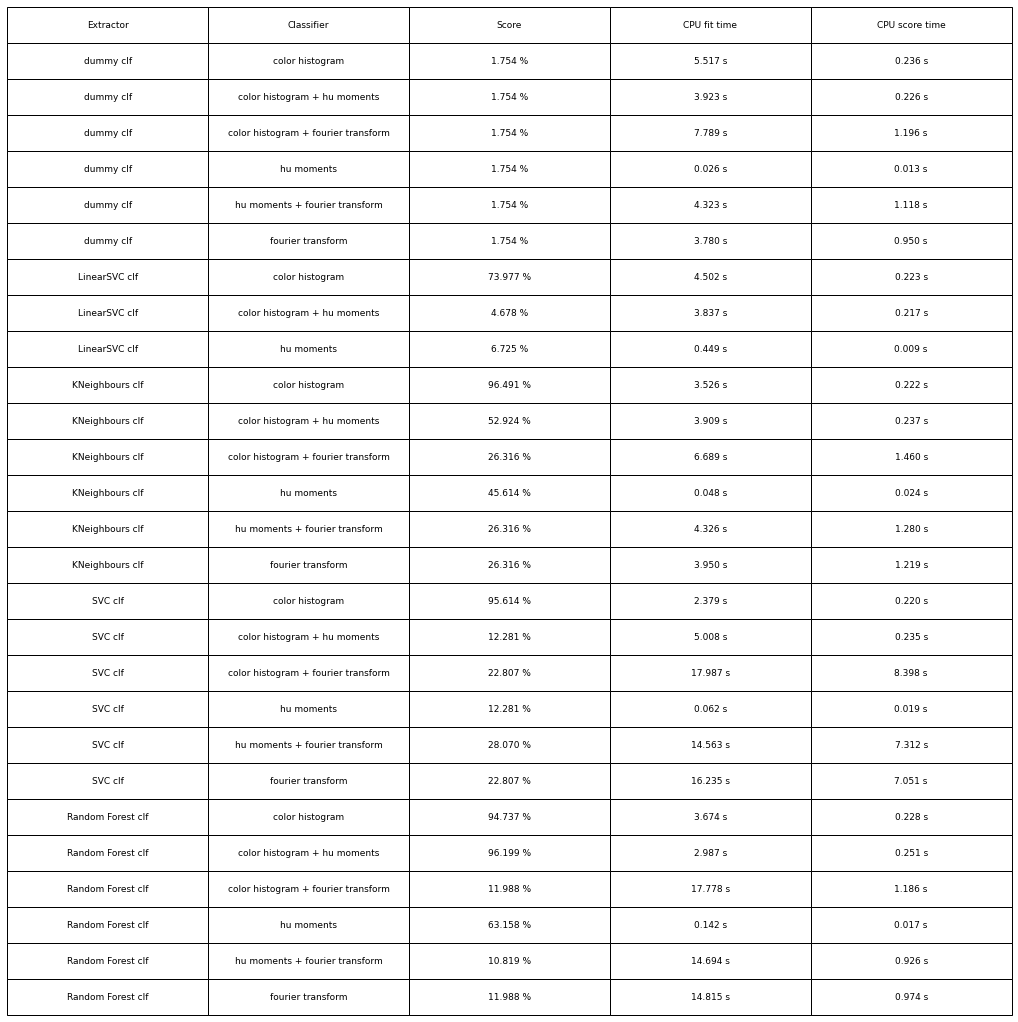

In [29]:
fig, ax =plt.subplots()
column_labels=["Extractor", "Classifier", "Score", "CPU fit time", "CPU score time"]
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=benchmark_opti,
                 colLabels=column_labels,
                 loc="center",
                 cellLoc="center")

table.set_fontsize(20)
table.scale(3, 3)

plt.show()